# Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.preprocessing import TargetEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
# from sklearn.pipeline import Pipeline # 因为需要过采样，所以选用ibmlearn的pipeline
from sklearn.metrics import classification_report,roc_auc_score,accuracy_score, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

warnings.filterwarnings('ignore')
import gc
import time
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

In [2]:
df_app = pd.read_csv('application_data.csv')
df_prev = pd.read_csv('previous_application.csv')

In [3]:
prev_null = (df_prev.isnull().mean()*100).sort_values(ascending=False)[:16]
prev_null

RATE_INTEREST_PRIVILEGED     99.643698
RATE_INTEREST_PRIMARY        99.643698
AMT_DOWN_PAYMENT             53.636480
RATE_DOWN_PAYMENT            53.636480
NAME_TYPE_SUITE              49.119754
NFLAG_INSURED_ON_APPROVAL    40.298129
DAYS_TERMINATION             40.298129
DAYS_LAST_DUE                40.298129
DAYS_LAST_DUE_1ST_VERSION    40.298129
DAYS_FIRST_DUE               40.298129
DAYS_FIRST_DRAWING           40.298129
AMT_GOODS_PRICE              23.081773
AMT_ANNUITY                  22.286665
CNT_PAYMENT                  22.286366
PRODUCT_COMBINATION           0.020716
AMT_CREDIT                    0.000060
dtype: float64

In [4]:
df_prev=df_prev.drop(['RATE_INTEREST_PRIVILEGED', 'RATE_INTEREST_PRIMARY', 'AMT_DOWN_PAYMENT',
       'RATE_DOWN_PAYMENT', 'NAME_TYPE_SUITE', 'NFLAG_INSURED_ON_APPROVAL',
       'DAYS_TERMINATION', 'DAYS_LAST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_FIRST_DUE', 'DAYS_FIRST_DRAWING', 'AMT_GOODS_PRICE',
       'AMT_ANNUITY', 'CNT_PAYMENT'],axis=1)
df_prev.dropna(subset=['PRODUCT_COMBINATION','AMT_CREDIT'],inplace=True)

In [5]:
prev_null = (df_prev.isnull().mean()*100).sort_values(ascending=False)[:7]
prev_null

SK_ID_PREV              0.0
NAME_PAYMENT_TYPE       0.0
NAME_YIELD_GROUP        0.0
NAME_SELLER_INDUSTRY    0.0
SELLERPLACE_AREA        0.0
CHANNEL_TYPE            0.0
NAME_PRODUCT_TYPE       0.0
dtype: float64

In [6]:
def aggregate_previous_app(prev_application):
    prev_application['NAME_CONTRACT_STATUS_APPROVED'] = (prev_application['NAME_CONTRACT_STATUS'] == 'Approved')
    prev_application['NAME_CONTRACT_STATUS_CANCELED'] = (prev_application['NAME_CONTRACT_STATUS'] == 'Canceled')
    prev_application['NAME_CONTRACT_STATUS_REFUSED'] = (prev_application['NAME_CONTRACT_STATUS'] == 'Refused')
    agg_funcs = {
        'NAME_CONTRACT_STATUS_APPROVED':['mean'],
        'NAME_CONTRACT_STATUS_CANCELED':['mean'],
        'NAME_CONTRACT_STATUS_REFUSED':['mean'],
        'AMT_CREDIT':['sum','mean','max'], 
        'AMT_APPLICATION':['sum','mean'],
    }
    prev_agg = prev_application.groupby('SK_ID_CURR').agg(agg_funcs)
    
    prev_agg.columns = ['_'.join(col).strip() for col in prev_agg.columns]
    
    prev_agg['PREV_LOAN_COUNT'] = prev_application.groupby('SK_ID_CURR').size()
    return prev_agg

In [7]:
df_prev_final = aggregate_previous_app(df_prev)

In [8]:
df_prev_final.columns= ['NAME_CONTRACT_STATUS_APPROVED',
 'NAME_CONTRACT_STATUS_CANCELED',
 'NAME_CONTRACT_STATUS_REFUSED',
 'PREV_AMT_CREDIT_TOTAL',
 'PREV_AMT_CREDIT_AVG',
 'PREV_AMT_CREDIT_MAX',
 'PREV_AMT_APPLICATION_TOTAL',
 'PREV_AMT_APPLICATION_AVG',
 'PREV_LOAN_COUNT']

In [9]:
df = df_app.merge(df_prev_final, on='SK_ID_CURR', how='left')
df.shape

(307511, 131)

In [10]:
del df_app,df_prev
gc.collect() 

20

# Data Preparation

## Data Inspection

In [11]:
df.shape

(307511, 131)

In [12]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_STATUS_APPROVED,NAME_CONTRACT_STATUS_CANCELED,NAME_CONTRACT_STATUS_REFUSED,PREV_AMT_CREDIT_TOTAL,PREV_AMT_CREDIT_AVG,PREV_AMT_CREDIT_MAX,PREV_AMT_APPLICATION_TOTAL,PREV_AMT_APPLICATION_AVG,PREV_LOAN_COUNT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.000000,0.000000,179055.0,179055.00,179055.0,179055.00,179055.00,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,1452573.0,484191.00,1035882.0,1306309.50,435436.50,3.0
2,100004,0,Revolving loans

In [13]:
print(df.columns)

Index(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'AMT_CREDIT', 'AMT_ANNUITY',
       ...
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'NAME_CONTRACT_STATUS_APPROVED',
       'NAME_CONTRACT_STATUS_CANCELED', 'NAME_CONTRACT_STATUS_REFUSED',
       'PREV_AMT_CREDIT_TOTAL', 'PREV_AMT_CREDIT_AVG', 'PREV_AMT_CREDIT_MAX',
       'PREV_AMT_APPLICATION_TOTAL', 'PREV_AMT_APPLICATION_AVG',
       'PREV_LOAN_COUNT'],
      dtype='object', length=131)


In [14]:
df.dtypes.value_counts()

float64    74
int64      41
object     16
Name: count, dtype: int64

In [15]:
obj_col = df.select_dtypes(include=['object']).columns
num_col = df.select_dtypes(include=['int64','float64']).columns
len(obj_col)+len(num_col)

131

In [16]:
# df[['FLAG_OWN_CAR','FLAG_OWN_REALTY']]=df[['FLAG_OWN_CAR','FLAG_OWN_REALTY']].replace('Y',1).replace('N',0)
# df[['EMERGENCYSTATE_MODE']]=df[['EMERGENCYSTATE_MODE']].replace('Yes',1).replace('No',0)
# df[['FLAG_OWN_CAR','FLAG_OWN_REALTY','EMERGENCYSTATE_MODE']].dtypes

In [17]:
# df[['CODE_GENDER']]=df[['CODE_GENDER']].replace('F',1).replace('XNA',1).replace('M',0)

## Missing Values

In [18]:
def check_na(df):
    missing_data = df.isna().mean().sort_values(ascending=False).reset_index()
    missing_data =missing_data[missing_data[0]>0]
    missing_data.columns = ['col','missing_rate(%)']
    missing_data['missing_rate(%)']=missing_data['missing_rate(%)']*100
    return missing_data

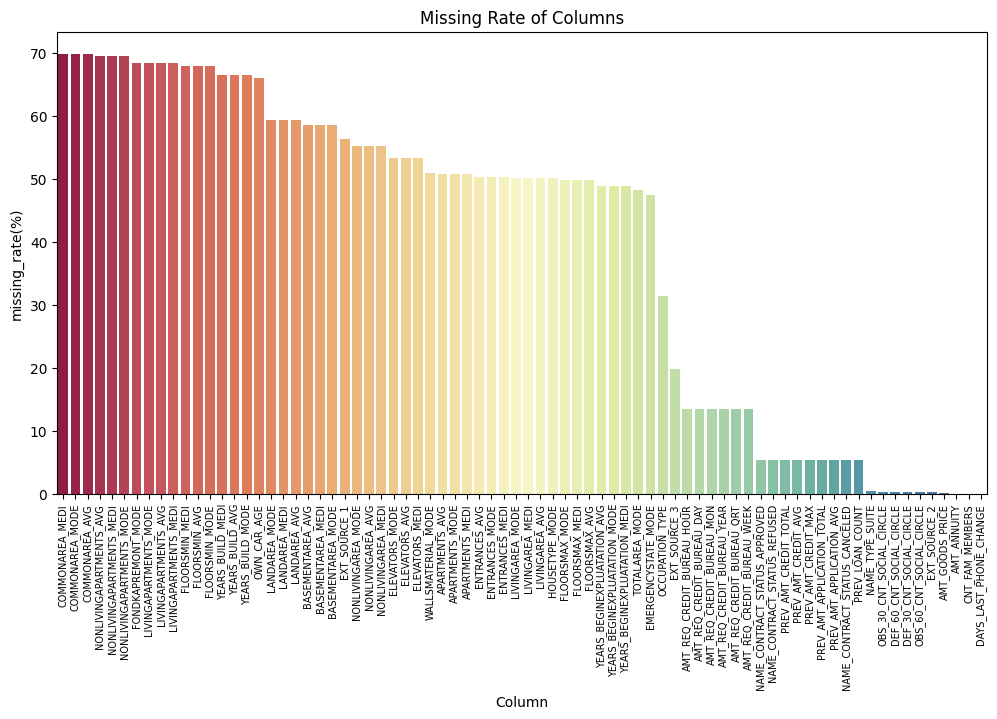

In [19]:
plt.figure(figsize=(12,6))
sns.barplot(data=check_na(df),x='col',y='missing_rate(%)',palette = "Spectral")
plt.xticks(rotation=90,fontsize=7)
plt.xlabel('Column')
plt.title('Missing Rate of Columns')
plt.show()

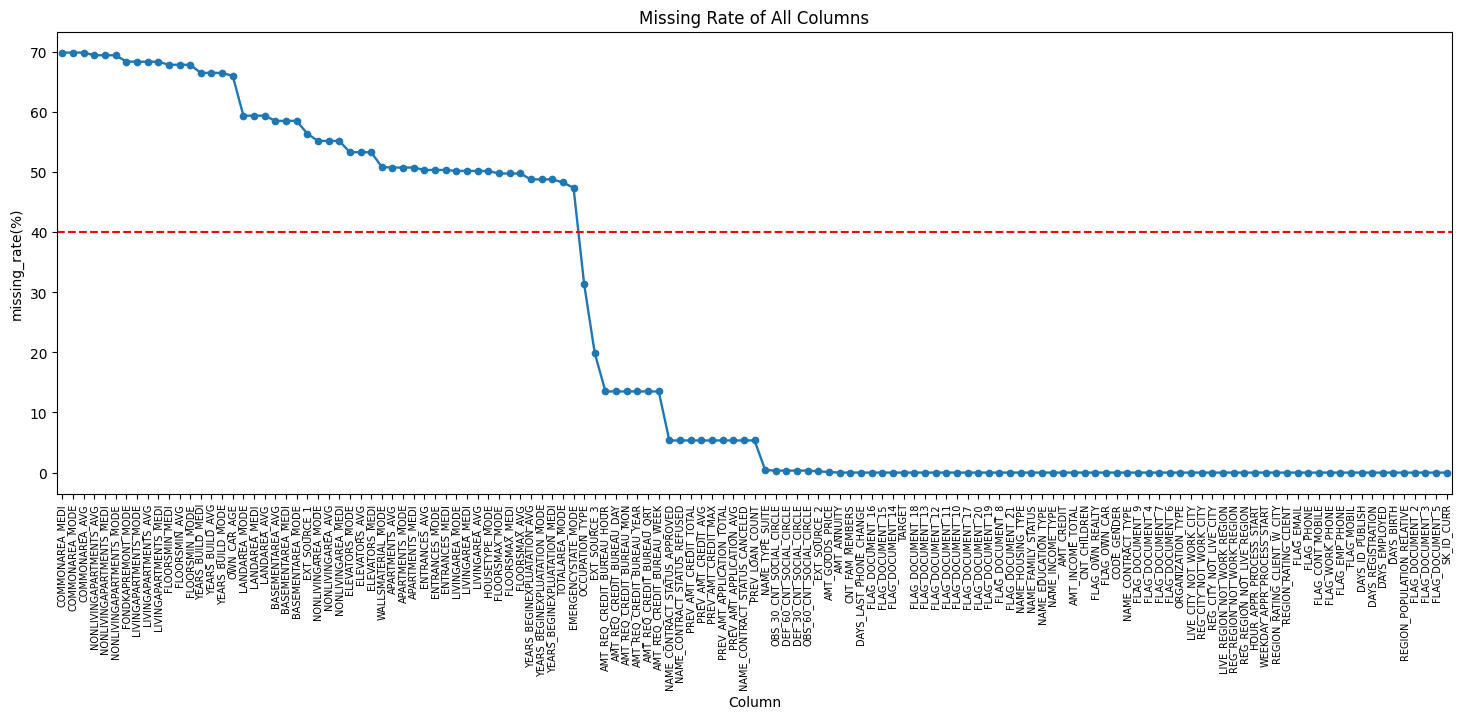

In [20]:
df_na = df.isna().mean().sort_values(ascending=False).reset_index()
df_na.columns = ['col','missing_rate(%)']
df_na['missing_rate(%)']= df_na['missing_rate(%)']*100

plt.figure(figsize=(18,6))
sns.pointplot(data=df_na,x='col',y='missing_rate(%)',lw=1.7)
plt.axhline(40,ls='--',color='r')
plt.xticks(rotation=90,fontsize=7)
plt.xlabel('Column')
plt.title('Missing Rate of All Columns')
plt.show()

In [21]:
len(df_na[df_na['missing_rate(%)']>0])

76

In [22]:
len(df_na[df_na['missing_rate(%)']>40])

49

+ 67 columns have missing values. 
+ 49 columns have over 40% values missing.
+ Let's check if we should drop columns with over 40% N/A.

In [23]:
df_na[df_na['missing_rate(%)']>40]

,col,missing_rate(%)
0,COMMONAREA_MEDI,69.872297
1,COMMONAREA_MODE,69.872297
2,COMMONAREA_AVG,69.872297
3,NONLIVINGAPARTMENTS_AVG,69.432963
4,NONLIVINGAPARTMENTS_MEDI,69.432963
5,NONLIVINGAPARTMENTS_MODE,69.432963
6,FONDKAPREMONT_MODE,68.386172
7,LIVINGAPARTMENTS_MODE,68.354953
8,LIVINGAPARTMENTS_AVG,68.354953
9,LIVINGAPARTMENTS_MEDI,68.354953


+ Aside from variables related to Housing, the column with top missing rate is 'OWN_CAR_AGE'.

In [24]:
df['OWN_CAR_AGE'].isna().sum()

202929

In [25]:
df['FLAG_OWN_CAR'].isna().sum()

0

In [26]:
df.loc[(df['OWN_CAR_AGE'].isna()==1)&(df['FLAG_OWN_CAR']=='Y')].shape[0]

5

+ The column 'FLAG_OWN_CAR' has no missing values, but 'OWN_CAR_AGE' has 202929 missing values.
+ There are only 5 records that the client owns a car but no car age is provided. So only 5 real N/A, and should be filled with 0.
+ Other N/A are just because the clients do not own a car. So fill N/A with -1. And distinguish them from clients that own a new car.

In [27]:
df.loc[(df['OWN_CAR_AGE'].isna()==1)&(df['FLAG_OWN_CAR']=='Y')].fillna(0,inplace=True)

In [28]:
df['OWN_CAR_AGE']=df['OWN_CAR_AGE'].fillna(-1)

In [29]:
# Drop columns with over 40% N/A  
msno = check_na(df)
msno_index = msno[msno['missing_rate(%)']>40].col
df = df.drop(msno_index,axis=1)
df.shape

(307511, 83)

In [30]:
check_na(df)

,col,missing_rate(%)
0,OCCUPATION_TYPE,31.345545
1,EXT_SOURCE_3,19.825307
2,AMT_REQ_CREDIT_BUREAU_HOUR,13.501631
3,AMT_REQ_CREDIT_BUREAU_DAY,13.501631
4,AMT_REQ_CREDIT_BUREAU_WEEK,13.501631
5,AMT_REQ_CREDIT_BUREAU_MON,13.501631
6,AMT_REQ_CREDIT_BUREAU_QRT,13.501631
7,AMT_REQ_CREDIT_BUREAU_YEAR,13.501631
8,NAME_CONTRACT_STATUS_APPROVED,5.350703
9,PREV_LOAN_COUNT,5.350703


In [31]:
def plot_distribution(df,col):
    axes = df[col].hist(figsize=(14,30),
                                                  xlabelsize=7,
                                                  ylabelsize=7,
                                                  bins=30,
                                                  layout=(15,6))
    for ax in axes.flatten():
        ax.set_title(ax.get_title(), fontsize=10) 
    
    plt.tight_layout()
    plt.show()

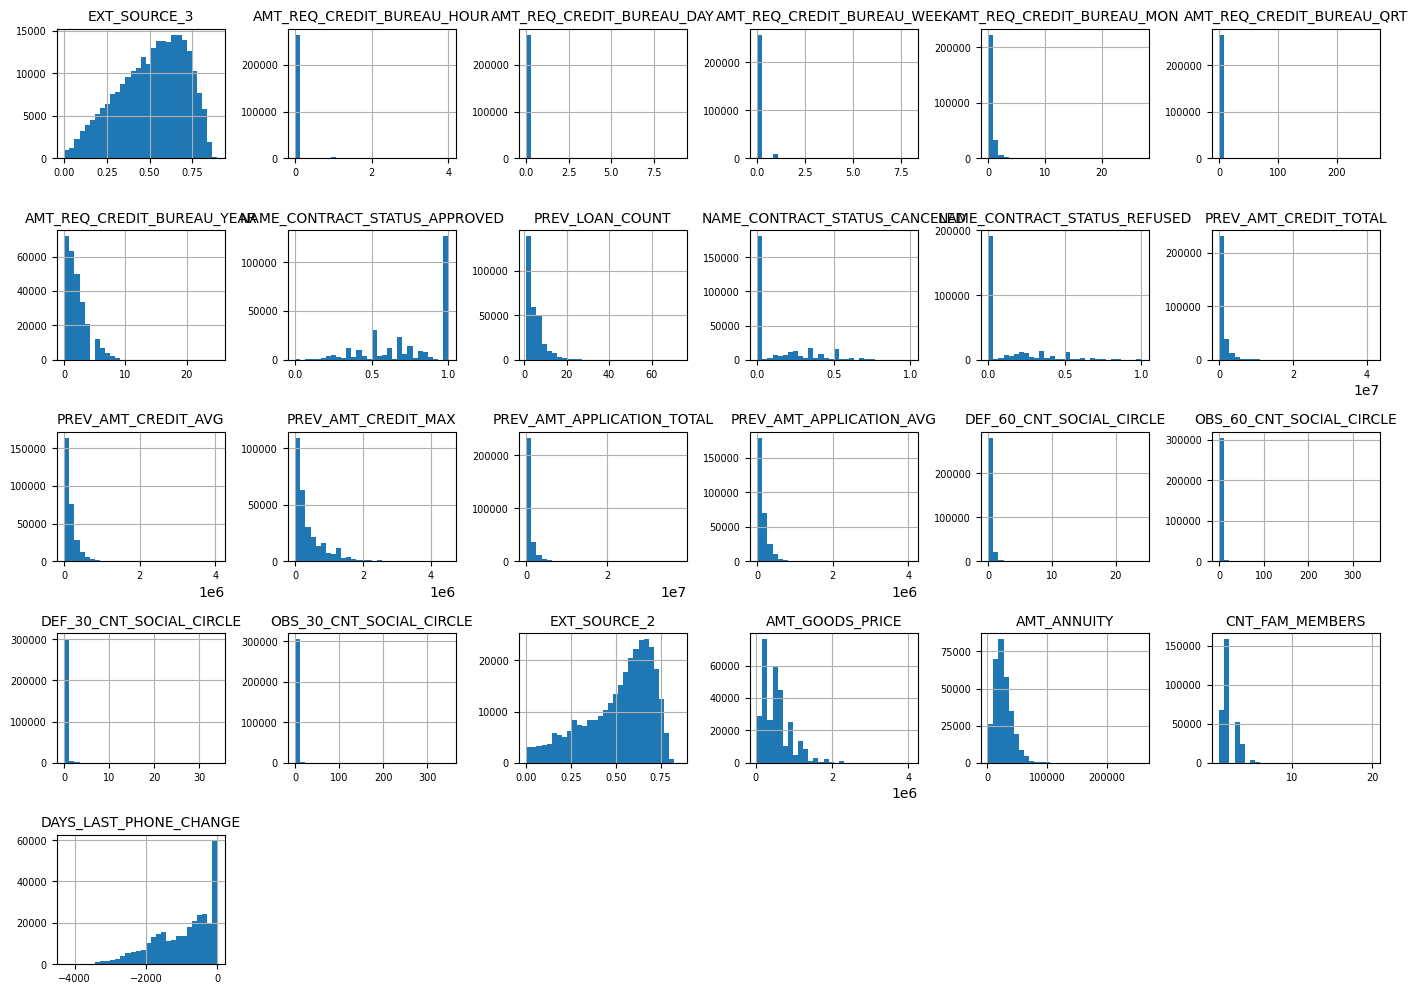

In [32]:
plot_distribution(df,check_na(df).col)

+ Drop columns that does not show much variance in their distribution while having N/A values.

In [33]:
df = df.drop([ 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE'],axis=1)

In [34]:
check_na(df)

,col,missing_rate(%)
0,OCCUPATION_TYPE,31.345545
1,EXT_SOURCE_3,19.825307
2,AMT_REQ_CREDIT_BUREAU_WEEK,13.501631
3,AMT_REQ_CREDIT_BUREAU_MON,13.501631
4,AMT_REQ_CREDIT_BUREAU_YEAR,13.501631
5,NAME_CONTRACT_STATUS_CANCELED,5.350703
6,NAME_CONTRACT_STATUS_APPROVED,5.350703
7,PREV_LOAN_COUNT,5.350703
8,NAME_CONTRACT_STATUS_REFUSED,5.350703
9,PREV_AMT_APPLICATION_AVG,5.350703


+ Inpute 'OCCUPATION_TYPE' according to 'NAME_EDUCATION_TYPE' and 'AMT_INCOME_TOTAL'

In [35]:
df[['OCCUPATION_TYPE','AMT_INCOME_TOTAL','NAME_EDUCATION_TYPE']].isna().sum()

OCCUPATION_TYPE        96391
AMT_INCOME_TOTAL           0
NAME_EDUCATION_TYPE        0
dtype: int64

In [36]:
pd.pivot_table(data=df,
               index='OCCUPATION_TYPE',
               columns='NAME_EDUCATION_TYPE',
               values='AMT_INCOME_TOTAL',
               aggfunc='median'
              ).sort_values(by='Academic degree')

NAME_EDUCATION_TYPE,Academic degree,Higher education,Incomplete higher,Lower secondary,Secondary / secondary special
OCCUPATION_TYPE,,,,,
Cooking staff,67500.0,153000.0,135000.0,112500.0,126000.0
Low-skill Laborers,67500.0,135000.0,128250.0,112500.0,121500.0
Sales staff,135000.0,157500.0,137565.0,135000.0,135000.0
High skill tech staff,157500.0,180000.0,157500.0,139500.0,153000.0
Drivers,162000.0,180000.0,180000.0,157500.0,180000.0
Security staff,195750.0,157500.0,135000.0,112500.0,135000.0
Cleaning staff,202500.0,130500.0,117000.0,112500.0,112500.0
Accountants,209250.0,180000.0,157500.0,186750.0,157500.0
Core staff,225000.0,171000.0,153000.0,112500.0,135000.0


In [37]:
def inpute_occupation_type(education,income_ranges,replacements):
    for (low,high),replacement in zip(income_ranges,replacements):
        condition = (df['NAME_EDUCATION_TYPE']==education) & (df['AMT_INCOME_TOTAL']> low) & (df['AMT_INCOME_TOTAL']<=high)
        df.loc[condition & df['OCCUPATION_TYPE'].isna(), 'OCCUPATION_TYPE'] = replacement

academic_degree_replacements = ['Low-skill Laborers','Sales staff','Drivers','Security staff','Realty agents','Private service staff']
academic_degree_income_ranges = [(0,100000),(100000,140000),(140000,175000),(175000,200000),(200000,230000),(230000,float('inf'))]
                                
higher_edu_replacements = ['Low-skill Laborers','Sales staff','Core staff','High skill tech staff','Realty agents','Managers']
higher_edu_income_ranges = [(0,140000),(140000,160000),(160000,175000),(175000,190000),(190000,230000),(230000,float('inf'))]

incomplete_higher_replacements = ['Low-skill Laborers','Security staff','Sales staff','Core staff','Realty agents','Private service staff','Managers']
incomplete_higher_income_ranges = [(0,130000),(130000,136000),(136000,145000),(145000,155000),(155000,170000),(170000,225000),(225000,float('inf'))]

lower_secondary_replacements = ['Low-skill Laborers','Sales staff','High skill tech staff','Secretaries','Drivers','Accountants','Realty agents','Managers']
lower_secondary_income_ranges = [(0,120000),(120000,140000),(140000,145000),(145000,150000),(150000,160000),(160000,190000),(190000,210000),(210000,float('inf'))]

secondary_replacements = ['Low-skill Laborers','Sales staff','Laborers','High skill tech staff','Private service staff','Realty agents','Managers']
secondary_income_ranges = [(0,130000),(130000,140000),(140000,150000),(150000,155000),(155000,170000),(170000,190000),(190000,float('inf'))]

In [38]:
inpute_occupation_type('Academic degree',academic_degree_income_ranges,academic_degree_replacements)
inpute_occupation_type('Higher education',higher_edu_income_ranges,higher_edu_replacements)
inpute_occupation_type('Incomplete higher',incomplete_higher_income_ranges,incomplete_higher_replacements)
inpute_occupation_type('Lower secondary',lower_secondary_income_ranges,lower_secondary_replacements)
inpute_occupation_type('Secondary / secondary special',secondary_income_ranges,secondary_replacements)

In [39]:
check_na(df)

,col,missing_rate(%)
0,EXT_SOURCE_3,19.825307
1,AMT_REQ_CREDIT_BUREAU_MON,13.501631
2,AMT_REQ_CREDIT_BUREAU_WEEK,13.501631
3,AMT_REQ_CREDIT_BUREAU_YEAR,13.501631
4,PREV_LOAN_COUNT,5.350703
5,PREV_AMT_APPLICATION_AVG,5.350703
6,PREV_AMT_APPLICATION_TOTAL,5.350703
7,PREV_AMT_CREDIT_MAX,5.350703
8,PREV_AMT_CREDIT_AVG,5.350703
9,PREV_AMT_CREDIT_TOTAL,5.350703


+ Try to compare the distribution of these columns with missing values before and after interpolate with linear model.

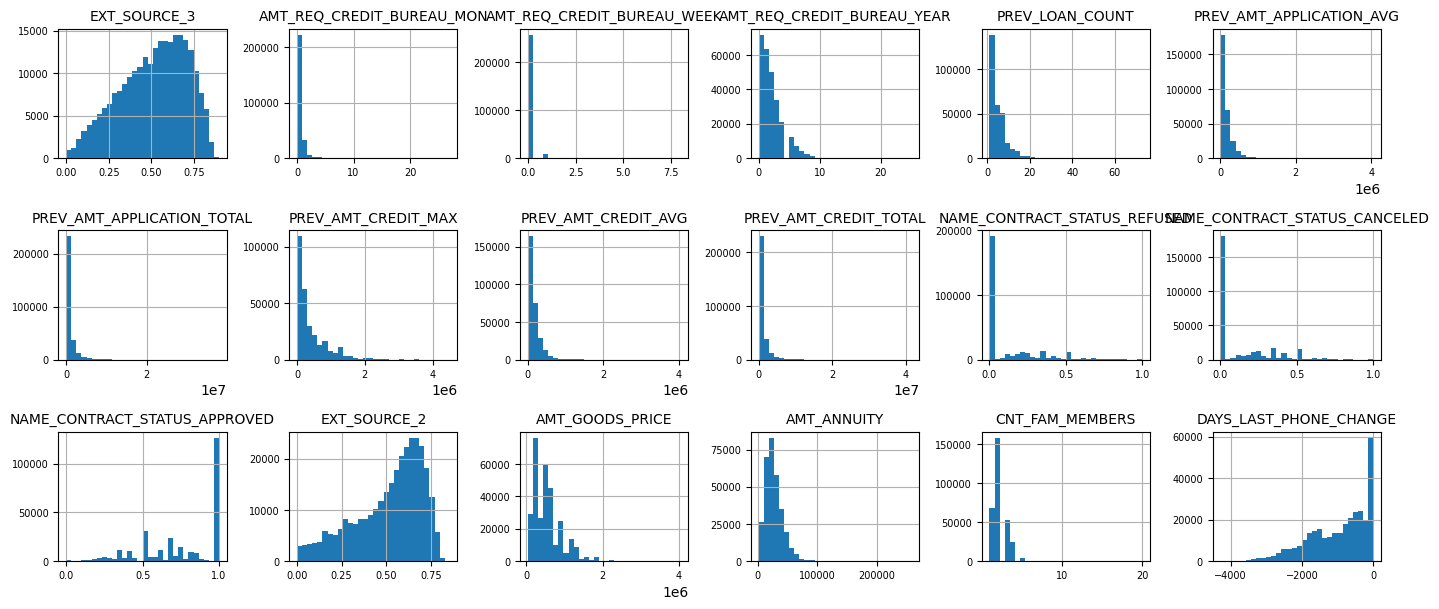

In [40]:
# Before inputation
plot_distribution(df,check_na(df).col)

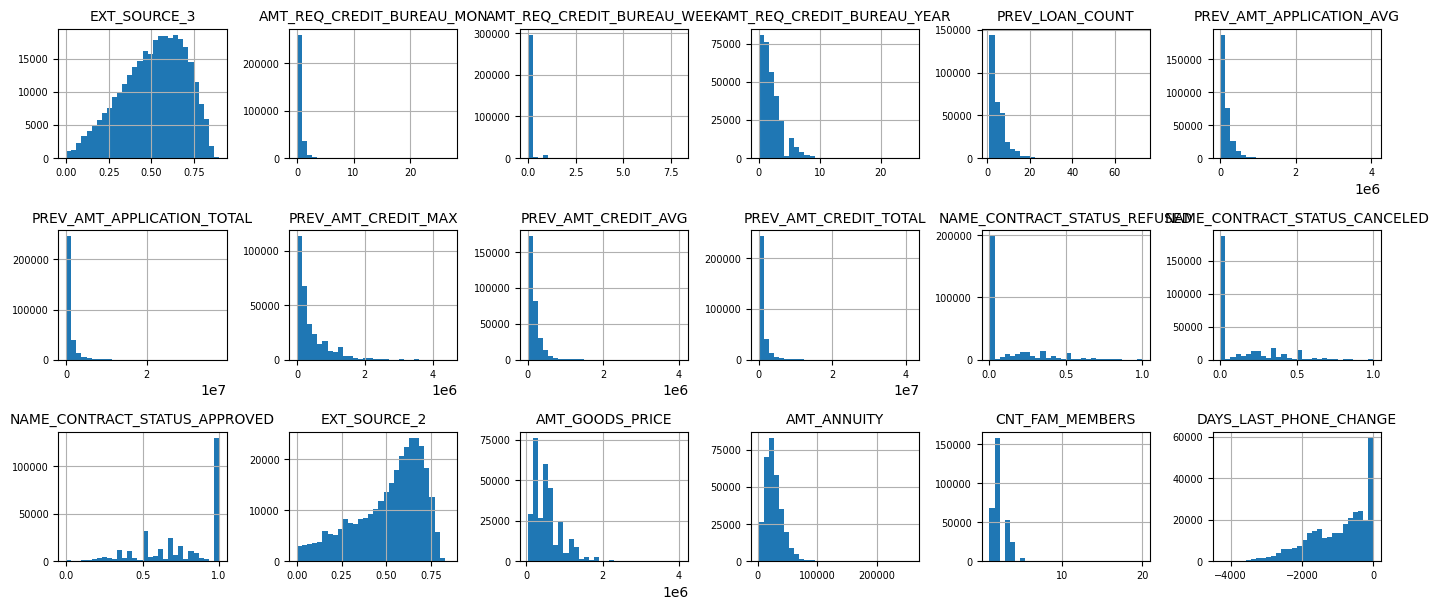

In [41]:
# After inputation
plot_distribution(df.interpolate(method='linear'),check_na(df).col)

+ The dsitribution remains unchanged.

In [42]:
df = df.interpolate(method='linear')

In [43]:
check_na(df)

,col,missing_rate(%)
0,NAME_TYPE_SUITE,0.420148


In [44]:
df['NAME_TYPE_SUITE'].value_counts()

NAME_TYPE_SUITE
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: count, dtype: int64

In [45]:
df = df.dropna(subset=['NAME_TYPE_SUITE'],axis=0)

In [46]:
df.isna().sum().sum()

0

In [47]:
df.shape

(306219, 76)

+ No missing values now. Lets check columns start with 'FLAG'.

In [48]:
flag_cols=[]
for i in df.columns:
    if i.startswith('FLAG'):
        flag_cols.append(i)
flag_cols

['FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_3',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_6',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_8',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21']

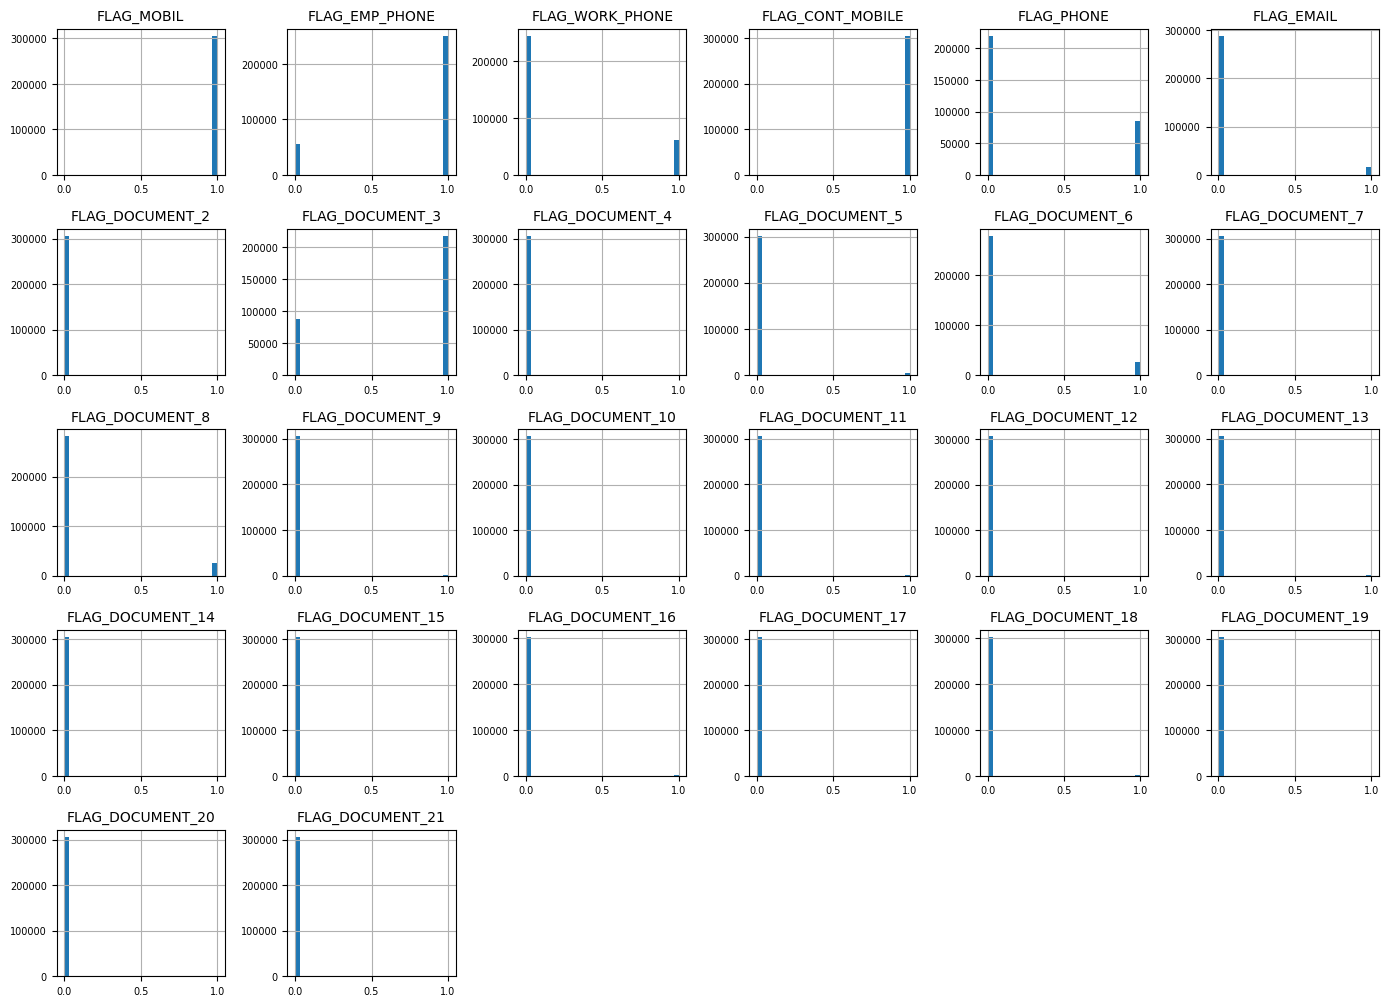

In [49]:
plot_distribution(df,flag_cols)

In [50]:
df = df.drop([
 'FLAG_MOBIL',
 'FLAG_CONT_MOBILE',
 'FLAG_DOCUMENT_2',
 'FLAG_DOCUMENT_4',
 'FLAG_DOCUMENT_5',
 'FLAG_DOCUMENT_7',
 'FLAG_DOCUMENT_9',
 'FLAG_DOCUMENT_10',
 'FLAG_DOCUMENT_11',
 'FLAG_DOCUMENT_12',
 'FLAG_DOCUMENT_13',
 'FLAG_DOCUMENT_14',
 'FLAG_DOCUMENT_15',
 'FLAG_DOCUMENT_16',
 'FLAG_DOCUMENT_17',
 'FLAG_DOCUMENT_18',
 'FLAG_DOCUMENT_19',
 'FLAG_DOCUMENT_20',
 'FLAG_DOCUMENT_21'],axis=1)

In [51]:
df['ORGANIZATION_TYPE'].value_counts()

ORGANIZATION_TYPE
Business Entity Type 3    67686
XNA                       55178
Self-employed             38259
Other                     16623
Medicine                  11145
Business Entity Type 2    10509
Government                10357
School                     8856
Trade: type 7              7798
Kindergarten               6853
Construction               6692
Business Entity Type 1     5963
Transport: type 4          5374
Trade: type 3              3471
Industry: type 9           3345
Industry: type 3           3269
Security                   3229
Housing                    2941
Industry: type 11          2698
Military                   2621
Bank                       2484
Agriculture                2446
Police                     2331
Transport: type 2          2191
Postal                     2152
Security Ministries        1965
Trade: type 2              1887
Restaurant                 1800
Services                   1568
University                 1322
Industry: type 7      

In [52]:
industry_mapping = {
    # Government & Public
    'Government': 'Government & Public',
    'Police': 'Government & Public',
    'Security Ministries': 'Government & Public',
    'Military': 'Government & Public',
    'Postal': 'Government & Public',
    'Emergency': 'Government & Public',
    'Electricity': 'Government & Public',
    'Security': 'Government & Public',
    
    # Education & Research
    'School': 'Education & Research',
    'Kindergarten': 'Education & Research',
    'University': 'Education & Research',
    'Culture': 'Education & Research',
    'Religion': 'Education & Research',
    
    # Healthcare & Social
    'Medicine': 'Healthcare & Social',
    'Legal Services': 'Healthcare & Social',
    'Cleaning': 'Healthcare & Social',
    'Services': 'Healthcare & Social',
    'Advertising': 'Healthcare & Social',
    'Realtor': 'Healthcare & Social',
    
    # Business & Finance
    'Business Entity Type 1': 'Business & Finance',
    'Business Entity Type 2': 'Business & Finance',
    'Business Entity Type 3': 'Business & Finance',
    'Bank': 'Business & Finance',
    'Insurance': 'Business & Finance',
    'Telecom': 'Business & Finance',
    'Mobile': 'Business & Finance',
    'Restaurant': 'Business & Finance',
    'Hotel': 'Business & Finance',
    
    # Industry & Manufacturing
    'Industry: type 1': 'Industry & Manufacturing',
    'Industry: type 2': 'Industry & Manufacturing',
    'Industry: type 3': 'Industry & Manufacturing',
    'Industry: type 4': 'Industry & Manufacturing',
    'Industry: type 5': 'Industry & Manufacturing',
    'Industry: type 6': 'Industry & Manufacturing',
    'Industry: type 7': 'Industry & Manufacturing',
    'Industry: type 8': 'Industry & Manufacturing',
    'Industry: type 9': 'Industry & Manufacturing',
    'Industry: type 10': 'Industry & Manufacturing',
    'Industry: type 11': 'Industry & Manufacturing',
    'Industry: type 12': 'Industry & Manufacturing',
    'Industry: type 13': 'Industry & Manufacturing',
    'Construction': 'Industry & Manufacturing',
    
    # Trade & Transportation
    'Trade: type 1': 'Trade & Transportation',
    'Trade: type 2': 'Trade & Transportation',
    'Trade: type 3': 'Trade & Transportation',
    'Trade: type 4': 'Trade & Transportation',
    'Trade: type 5': 'Trade & Transportation',
    'Trade: type 6': 'Trade & Transportation',
    'Trade: type 7': 'Trade & Transportation',
    'Transport: type 1': 'Trade & Transportation',
    'Transport: type 2': 'Trade & Transportation',
    'Transport: type 3': 'Trade & Transportation',
    'Transport: type 4': 'Trade & Transportation',
    'Agriculture': 'Trade & Transportation',
    'Housing': 'Trade & Transportation',
    
    # Other
    'XNA': 'Other',
    'Self-employed': 'Other',
    'Other': 'Other'
}
df['ORGANIZATION_TYPE_MAPPED'] = df['ORGANIZATION_TYPE'].map(industry_mapping)

In [53]:
df['CODE_GENDER'].replace('XNA',np.nan)
df=df.dropna(subset=['CODE_GENDER'],axis=0)

+ New Features

In [54]:
df['DEBT_TO_INCOME_RATIO'] = df['AMT_CREDIT']/df['AMT_INCOME_TOTAL']
df['INCOME_PER_FAMILY_MEMBER'] = df['AMT_INCOME_TOTAL']/df['CNT_FAM_MEMBERS']
df['DEBT_PER_FAMILY_MEMBER'] = df['AMT_CREDIT'] / df['CNT_FAM_MEMBERS']

In [55]:
df = df.drop(['SK_ID_CURR','CNT_CHILDREN','ORGANIZATION_TYPE'],axis=1)

In [56]:
df.shape

(306219, 58)

## Distribution of the target variable

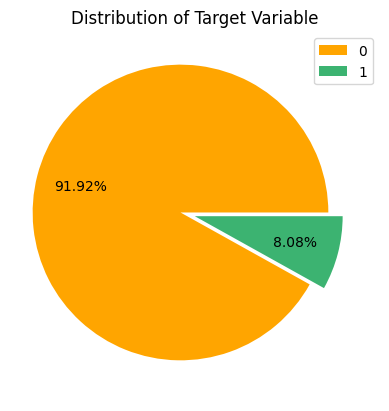

In [57]:
plt.pie(df['TARGET'].value_counts(),autopct='%1.2f%%',pctdistance=0.7,explode=[0.1,0],colors=['orange','mediumseagreen'])
plt.legend(labels=df['TARGET'].value_counts().index)
plt.title('Distribution of Target Variable')
plt.show()

The target variable is highly inbalanced.

In [58]:
obj_col = df.select_dtypes(include=['object',]).columns
num_col = df.select_dtypes(include=['float64','int64']).columns
len(obj_col)+len(num_col)

58

# Modelling


In [59]:
def plot_confusion_matrix(y,y_predict):
    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax,cmap='Spectral',fmt="d");
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not defalut', 'default']); ax.yaxis.set_ticklabels(['did not default', 'default']) 
    plt.show() 

In [60]:
# # --------------------------先过采样再分训练集 数据泄露，导致分数虚高---------------------------------------------
# X = df.drop('TARGET',axis=1)
# y = df['TARGET']
# obj_col = X.select_dtypes(include=['object']).columns
# num_col = X.select_dtypes(include=['float64','int64']).columns
# ohe = OneHotEncoder(sparse_output=False,drop='first')
# X_ohe = pd.DataFrame(ohe.fit_transform(X[obj_col]),index=X.index)
# undersample = RandomUnderSampler(sampling_strategy=0.15,random_state=42)
# X_ohe,y = undersample.fit_resample(X_ohe,y)
# smote = SMOTE()
# X_ohe,y = smote.fit_resample(X_ohe,y)
# X_train,X_test,y_train,y_test = train_test_split(X_ohe,y,test_size=0.3,random_state=42,stratify=y)
# rfc = RandomForestClassifier(n_estimators=200)
# rfc.fit(X_train,y_train)
# y_pred = rfc.predict(X_test)
# print(classification_report(y_test,y_pred))

In [61]:
X = df.drop('TARGET',axis=1)
y = df['TARGET']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [62]:
obj_col = X.select_dtypes(include=['object']).columns
num_col = X.select_dtypes(include=['float64','int64']).columns

In [63]:
ohe = OneHotEncoder(sparse_output=False,drop='first')
X_train_ohe = pd.DataFrame(ohe.fit_transform(X_train[obj_col]),index=X_train.index)
X_train_ohe.columns=ohe.get_feature_names_out(obj_col)
X_train = pd.concat([X_train.drop(obj_col,axis=1),X_train_ohe],axis=1)
X_test_ohe = pd.DataFrame(ohe.transform(X_test[obj_col]),index=X_test.index)
X_test_ohe.columns=ohe.get_feature_names_out(obj_col)
X_test = pd.concat([X_test.drop(obj_col,axis=1),X_test_ohe],axis=1)

+ First Logistic Regression

In [64]:
lg = LogisticRegression()
lg.fit(X_train,y_train)
y_pred = lg.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96     84439
           1       0.33      0.00      0.00      7427

    accuracy                           0.92     91866
   macro avg       0.63      0.50      0.48     91866
weighted avg       0.87      0.92      0.88     91866



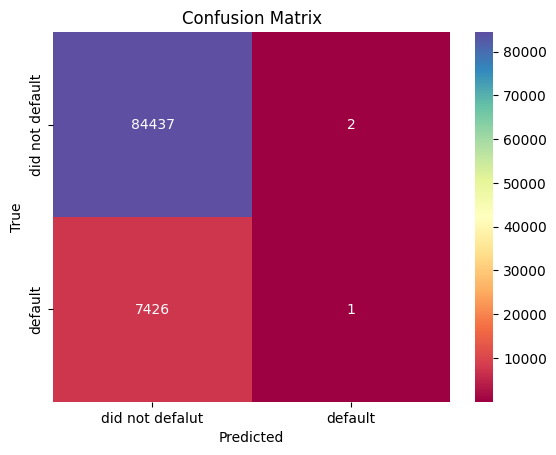

In [65]:
plot_confusion_matrix(y_test,y_pred)

In [66]:
y.value_counts()/len(y)

TARGET
0    0.919159
1    0.080841
Name: count, dtype: float64

**Data imbalance should be handled**

+ Second Logistic Regression

In [67]:
# Resample after split the data
undersample = RandomUnderSampler(sampling_strategy=0.5,random_state=42)
X_train_res,y_train_res = undersample.fit_resample(X_train,y_train)
smote = SMOTE()
X_train_res_res,y_train_res_res = smote.fit_resample(X_train_res,y_train_res)

In [68]:
lg = LogisticRegression()
lg.fit(X_train_res_res,y_train_res_res)
y_proba = lg.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.46).astype(int)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.95      0.40      0.56     84439
           1       0.10      0.74      0.17      7427

    accuracy                           0.42     91866
   macro avg       0.52      0.57      0.36     91866
weighted avg       0.88      0.42      0.53     91866



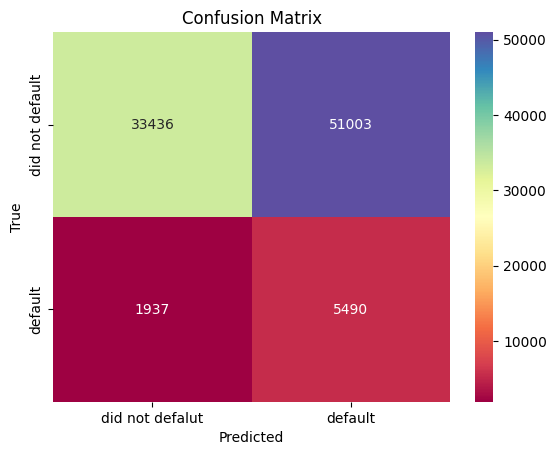

In [69]:
plot_confusion_matrix(y_test,y_pred)

+ Random Forest

In [70]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train_res_res,y_train_res_res)

RandomForestClassifier(n_estimators=200)

In [85]:
y_proba = rfc.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.35).astype(int)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.61      0.75     84439
           1       0.14      0.74      0.24      7427

    accuracy                           0.62     91866
   macro avg       0.55      0.67      0.49     91866
weighted avg       0.90      0.62      0.70     91866



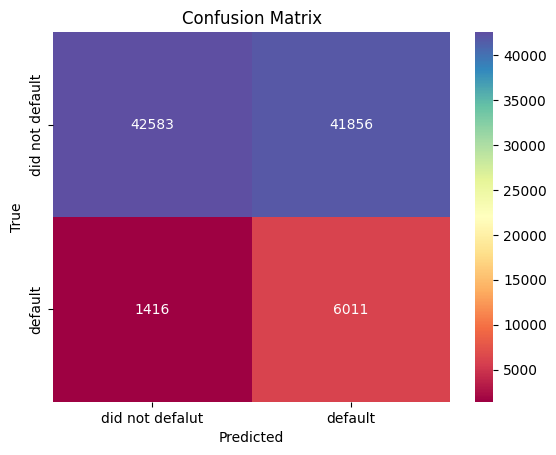

In [72]:
plot_confusion_matrix(y_test,y_pred)

+ XGBoost

In [73]:
# xgb = XGBClassifier(colsample_bytree= 1.0, gamma= 0.0, learning_rate=0.15, max_depth= 8, n_estimators=200, subsample= 0.7875742019856633)
# xgb.fit(X_train_res_res,y_train_res_res)
# y_pred = rfc.predict(X_test)
# print(classification_report(y_test,y_pred))

# Best Parameters: OrderedDict({'colsample_bytree': 1.0, 'gamma': 0.02131876938053273, 'learning_rate': 0.0756126641370627, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.6382255233172518})

In [74]:
search_spaces = {
    'n_estimators': Integer(100, 200),
    'max_depth': Integer(3, 8),
    'learning_rate': Real(0.01, 0.15, prior='log-uniform'),
    'gamma': Real(0, 3),
    'subsample': Real(0.5, 1.0),
    'colsample_bytree': Real(0.5, 1.0)
}

bayes_cv = BayesSearchCV(
    estimator=XGBClassifier(
        # scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1])
    ),
    search_spaces=search_spaces,
    cv=5,  
    n_iter=30,  
    scoring='f1', 
    random_state=42,
    n_jobs=-1 
)

bayes_cv.fit(X_train_res_res,y_train_res_res)

print("Best Parameters:", bayes_cv.best_params_)

Best Parameters: OrderedDict({'colsample_bytree': 1.0, 'gamma': 0.02131876938053273, 'learning_rate': 0.0756126641370627, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.6382255233172518})


In [82]:
# Predict with the best model
best_model = bayes_cv.best_estimator_
y_proba = best_model.predict_proba(X_test)[:, 1]
y_pred = (y_proba > 0.28).astype(int) 

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.60      0.74     84439
           1       0.14      0.75      0.24      7427

    accuracy                           0.61     91866
   macro avg       0.55      0.68      0.49     91866
weighted avg       0.90      0.61      0.70     91866



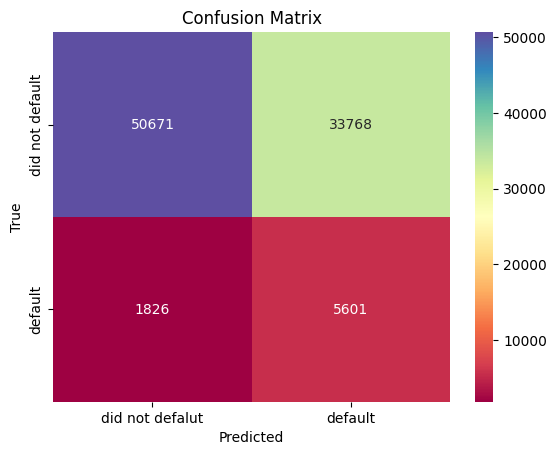

In [83]:
plot_confusion_matrix(y_test,y_pred)